<a id='introduction'></a>
# BNFO - Final Project
**Code:** Edahí Gonzalez-Avalos, Elly Poretsky, Anya Umlauf  
**Date:** 6.15.18

### Table of Content
1. [Introduction](#introduction)
2. [Functions](#functions)
3. [Omics Analysis](#omics)
  * [Transcriptome](#cluster)
  * [Proteome](#heatmap)  
4. [Network Analysis](#qc)
  * [Parsimonious Composite Network (PCNet)](#PCNet)

**Introduction**

This is the final notebook

<a id='functions'></a>
## Functions


In [1]:
%matplotlib inline

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import warnings
from scipy.stats import pearsonr
import itertools
import matplotlib as mpl
import scipy

warnings.filterwarnings('ignore')

In [2]:
print "NetworkX version:", nx.__version__
print "Pandas version:", pd.__version__
print "MatPlotLib version:", mpl.__version__
print "SciPy version:", scipy.__version__
print "NumPy version:", np.__version__

NetworkX version: 1.11
Pandas version: 0.22.0
MatPlotLib version: 1.3.1
SciPy version: 0.13.0b1
NumPy version: 1.11.0


<a id='associated'></a>
## Overview of associated SNPs and genes

In [3]:
"""Load all the association data"""
gene_summary = pd.read_csv("data/gene_level_summary_stats_pmid_25056061.txt", sep = "\t")
snp_summary = pd.read_csv("data/snp_level_summary_stats_pmid_25056061.txt", sep = "\t")
snp_summary.head(3)

,snpid,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
0,rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.16055
1,rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
2,rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,.


In [4]:
"""Load all the association data"""
genes = gene_summary[["Gene", "Chr","TopSNP Pos","TopSNP P-Value", "SNP Distance"]].copy()
snps = snp_summary[["snpid", "hg18chr","bp","pval"]].copy()
#genes = genes[genes["TopSNP P-Value"]<1e-7]
#filter_gene_summary.head()
#plt.figure()
#filter_gene_summary.plot(kind='bar')

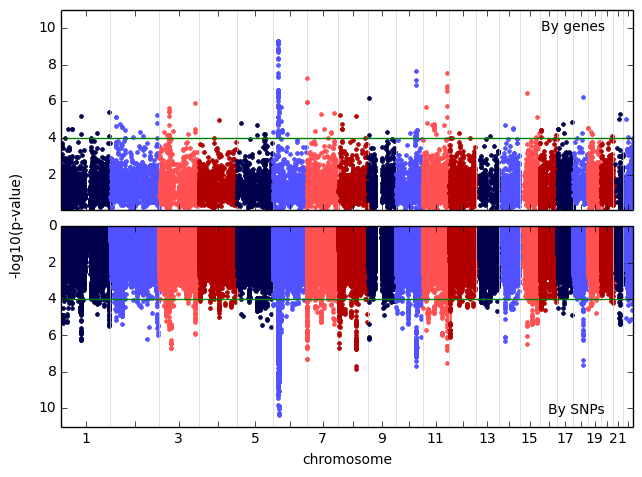

In [40]:
from assocplots.manhattan import *
chrs = [str(i) for i in range(1,23)]
chrs_names = np.array([str(i) for i in range(1,23)])
chrs_names[1::2] = ''
cmap = plt.get_cmap('seismic')
colors = [cmap(i) for i in [0.0,0.33,0.67,0.90]]

mpl.rcParams['figure.figsize']=7.375, 5.375
manhattan(     genes["TopSNP P-Value"], genes["TopSNP Pos"].astype(int), genes["Chr"].astype(str), 'By genes',
               snps["pval"], snps["bp"].astype(int), snps["hg18chr"].astype(str), 'By SNPs',
               type='inverted',
               chrs_plot=[str(i) for i in range(1,23)],
               chrs_names=chrs_names,
               cut = 0,
               title='',
               xlabel='chromosome',
               ylabel='-log10(p-value)',
               lines= [4],
               top1 = 11,
               top2 = 11,
               colors = colors)
plt.subplots_adjust(hspace=0.08)

In [41]:
"""Select amount of genes based on p-values"""
filtered_genes = genes[genes["TopSNP P-Value"]<0.00558]
print("There are", len(filtered_genes), "genes in the filtered gene set.\n")
print(filtered_genes.head())
candidate_genes = list(filtered_genes["Gene"])

('There are', 2001, 'genes in the filtered gene set.\n')
        Gene  Chr  TopSNP Pos  TopSNP P-Value  SNP Distance
0   HIST1H4K    6  27913234.0    5.071180e-10        6304.0
1  HIST1H2AK    6  27913234.0    5.071180e-10         402.0
2  HIST1H2BN    6  27913234.0    5.071180e-10        1184.0
3  HIST1H2AL    6  27942064.0    7.053790e-10         979.0
4   HIST1H1B    6  27942064.0    7.053790e-10         484.0


<a id='PCNet'></a>
## Parsimonious Composite Network (PCNet)

In [8]:
"""Load ndex network"""
from ndex.networkn import NdexGraph
ndex_graph = NdexGraph(server="http://ndexbio.org", 
                  uuid='f93f402c-86d4-11e7-a10d-0ac135e8bacf')

In [9]:
""""Convert the NDEx network into a networkx network"""
import networkx as nx
nx_graph = nx.Graph(ndex_graph)
names = nx.get_node_attributes(nx_graph, 'name')
nx_graph = nx.relabel_nodes(nx_graph, names)

In [10]:
"""A function to find the neighbors of a """
def neighbors(graph, seed_node, layers=1):
    G=nx.Graph() # Start empty network
    G.add_node(seed_node) # Add seed node
    neighbors = [] # Make a list of neighbors, just to avoid re-iterating over loop
    for i in range(layers): # While less than min_nodes, keep adding another layer of neighbors
        for node in (node for node in G.nodes() if node not in neighbors): # add to each node neighbors, skip ones already added
            neighbors.append(node)
            next_neighbors = graph.neighbors(node)
            G.add_nodes_from(next_neighbors)
            G.add_edges_from(zip([node]*len(next_neighbors), next_neighbors)) # add edges node-neighbor
    return G

In [11]:
"""Load the networkd"""
G=nx.Graph()
for gene in candidate_genes:
    if gene not in nx_graph.nodes():
        continue
    G = nx.compose(G, neighbors(nx_graph, gene, 1))
node_attributes = {}
for node in G.nodes():
    if node in candidate_genes:
        node_attributes[node] = "SNP"
    else:
        node_attributes[node] = "neighbor"
nx.set_node_attributes(G, 'is_mapped', node_attributes)

In [12]:
"""Remove nodes that are not neighbors and not in the p-val list"""
G1 = nx_graph.copy()
remove_nodes = [node for node in nx_graph.nodes() if node not in G.nodes()]
G1.remove_nodes_from(remove_nodes)

<a id='omics'></a>
## Omics Analysis

In [13]:
"""Detect community using python louvain alogorithm"""
# https://media.readthedocs.org/pdf/python-louvain/latest/python-louvain.pdf
import community
from collections import defaultdict

def community_detector(graph, candidate_genes, resolution=1.0):
    part = community.best_partition(graph, resolution=resolution)
    community_dict = defaultdict(list)
    candidate_dict = defaultdict(list)
    for key, val in part.iteritems():
        community_dict[val].append(key)
        if key in candidate_genes:
            candidate_dict[val].append(key)
    return (community_dict, candidate_dict)

In [14]:
M3 = community_detector(G1, candidate_genes, resolution=0.5)
print (len(M3[0]), len(M3[1]))
for key, val in M3[1].iteritems():
    ratio = len(val)*1.0/len(M3[0][key])
    if ratio > 0.01:
        print (key, len(val), M3[0][key], ratio)

(25, 23)
(0, 46, [u'UBE2Q1', u'UBE2Q2', u'MVB12B', u'FBXL13', u'FBXL12', u'FBXL15', u'FBXL17', u'FBXL16', u'FBXL18', u'CADPS2', u'UBE2QL1', u'FBXL14', u'FBXL19', u'RNF130', u'FAM188A', u'MTURN', u'KLHDC8B', u'KLHDC8A', u'CUEDC1', u'LIMD1', u'TMEM255A', u'FBXO18', u'UBE2J1', u'FBXO10', u'FBXO16', u'FBXO17', u'FBXO15', u'UFD1L', u'RNF7', u'RNF4', u'RNF5', u'PPP1R27', u'CDC34', u'LONRF1', u'UNKL', u'NUDCD3', u'LRSAM1', u'SMURF1', u'SMURF2', u'ESPNL', u'KCNA6', u'ANKRD30BL', u'KLHL25', u'GPR75-ASB3', u'SPRYD4', u'KLHDC5', u'KLHDC1', u'TRIM47', u'TRIM44', u'TRIM43', u'TRIM40', u'TRIM41', u'KLHL11', u'KLHL12', u'KLHL13', u'KLHL14', u'KLHL15', u'KLHL17', u'KLHL18', u'RNF135', u'MDM2', u'SLC25A37', u'RLIM', u'ANKDD1B', u'WSB1', u'ANAPC5', u'ANAPC4', u'ANAPC7', u'RFFL', u'ARRDC4', u'ARRDC5', u'ARRDC2', u'ARRDC3', u'TRIM9', u'TRIM4', u'TRIM7', u'FBXW12', u'FBXW8', u'FBXW9', u'FBXW2', u'FBXW4', u'FBXW5', u'FBXW7', u'SH3RF1', u'RFPL4B', u'NEURL1B', u'SENP8', u'RGAG1', u'UBA52', u'ELOC', u'WWP2', u

## Create all gene score dictionaries to be used for prioritization

In [15]:
"""Load all p_val based scores"""
p_df = pd.DataFrame({"p_val":-np.log10(list(filtered_genes["TopSNP P-Value"]))}, index=list(filtered_genes["Gene"]))
pval_dict = p_df.to_dict()["p_val"]
pval_scores = {key: rank for rank, key in enumerate(sorted(pval_dict, key=pval_dict.get, reverse=False), 1)}

In [16]:
"""Load all the centrality based scores"""
candidate_centrality = {}
for community, gene_list in M3[1].iteritems():
    G_community = G1.copy()
    keep_nodes = M3[0][community]
    G_community.subgraph(keep_nodes)
    centrality = nx.degree_centrality(G_community)
    for gene in gene_list:
        candidate_centrality[gene] = centrality[gene]
cent_score = {key: rank for rank, key in enumerate(sorted(candidate_centrality, key=candidate_centrality.get, reverse=False), 1)}

In [17]:
"""Load all the brain related proteomic data"""
brain_samples = [('caudate', 'synapses'),('hypothalamus', 'neuronal cells'),('pituitary gland', 'cells in posterior '),('cerebellum', 'cells in granular layer'),('cerebral cortex', 'neuropil'),('caudate', 'neuronal projections'),('cerebellum', 'Purkinje cells'),('hippocampus', 'neuronal cells'),('cerebral cortex', 'endothelial cells'),('cerebral cortex', 'neuronal cells'),('hypothalamus', 'synapses'),('cerebral cortex', 'synapses'),('hippocampus', 'glial cells'),('hypothalamus', 'neuronal projections'),('cerebral cortex', 'neuronal projections'),('hippocampus', 'neuronal projections'),('hippocampus', 'synapses'),('pituitary gland', 'cells in anterior '),('cerebral cortex', 'glial cells'),('caudate', 'neuronal cells'),('hypothalamus', 'glial cells'),('cerebellum', 'cells in molecular layer'),('caudate', 'glial cells')]
brain_samples = [str(i) for i in brain_samples]
atlas_raw = pd.read_csv("data/new_protein_atlas.csv", sep = ",", index_col=0)
brain_atlas = atlas_raw[brain_samples]
brain_atlas = brain_atlas.ix[candidate_genes]
brain_atlas = brain_atlas.fillna(0)

brain_mean = dict(brain_atlas.mean(axis=1))
brain_mean_score = {key: rank for rank, key in enumerate(sorted(brain_mean, key=brain_mean.get, reverse=False), 1)}

In [43]:
"""Shortest path calculation"""
shortest_path = pd.read_csv("data/Gene_Shortest_Path_Score_2000.csv", sep = ",", index_col=0)
shortest_path = shortest_path.ix[candidate_genes]
shortest_path = dict(shortest_path["Value"])
shortest_path_scores = {key: rank for rank, key in enumerate(sorted(shortest_path, key=shortest_path.get, reverse=True), 1)}

In [44]:
"""Using iterativeWGCNA script and their eigengenes(of brain related)*membership(as centrality)"""
# Membership based - https://github.com/cstoeckert/iterativeWGCNA/blob/master/iterativeWGCNA/iterativeWGCNA.py
atlas_eigengenes = pd.read_csv("data/wgcna-eigengenes.txt", sep = "\t", index_col=0)
atlas_membership_cerebral = dict(atlas_eigengenes["cerebral.cortex"])

atlas_membership = pd.read_csv("data/wgcna-membership.txt", sep = "\t", index_col=0)
atlas_membership.replace({"Module": atlas_membership_cerebral}, inplace=True)
atlas_membership["bla"] = atlas_membership["Module"]*atlas_membership["kME"]

atlas_membership = atlas_membership["bla"]
atlas_membership = atlas_membership.ix[candidate_genes]
atlas_membership = atlas_membership.fillna(0)
atlas_membership = dict(atlas_membership)
atlas_membership_score = {key: rank for rank, key in enumerate(sorted(atlas_membership, key=atlas_membership.get, reverse=False), 1)}

## Prioritizing Gene Candidates

In [45]:
"""Borda function for adding any list of candidates"""
# https://github.com/morinokami/social_choice
# https://academic.oup.com/bioinformatics/article/31/7/1034/180684
def borda(score_dict_list, candidate_genes):
    '''Prints who wins by the Borda count'''
    counts = {}
    candidates = candidate_genes
    for candidate in candidates:
        counts[candidate] = 0

    max_point = len(candidates)
    for scores in score_dict_list:
        for gene, score in scores.iteritems():
            counts[gene] += score

    return counts

In [46]:
"""Borda score with just the p-vals for comparison"""
pval_scores = borda([pval_scores], candidate_genes)
pval_prioritzied_gene_candidate_list = []
count = 0
for key, value in sorted(pval_scores.iteritems(), key=lambda (k,v): (v,k), reverse=True): 
    count += 1
    pval_prioritzied_gene_candidate_list.append(key)

In [47]:
"""
The Borda count is a family of single-winner election methods in which voters rank options or candidates 
in order of preference. The Borda count determines the outcome of a debate or the winner of an election 
by giving each candidate, for each ballot, a number of points corresponding to the number of candidates ranked lower. Once all votes have been counted the option or candidate with the most points is the winner. Because it tends to elect broadly-acceptable options or candidates, rather than those preferred by a majority, the Borda count is often described as a consensus-based voting system rather than a majoritarian one.
"""
borda_scores = borda([cent_score, pval_scores, brain_mean_score, atlas_membership_score, shortest_path_scores], candidate_genes)
prioritzied_gene_candidate_list = []
count = 0
for key, value in sorted(borda_scores.iteritems(), key=lambda (k,v): (v,k), reverse=True): 
    count += 1
    prioritzied_gene_candidate_list.append(key)
    print ("%s %s %s" % (count, key, value))

1 AKT3 9372
2 HIST1H3C 9014
3 STAG1 8792
4 SYNJ1 8752
5 HIST1H2BN 8718
6 UBAP2L 8594
7 SMARCA5 8576
8 SF3B1 8576
9 PHF3 8558
10 HSPE1 8551
11 HIST1H2BL 8550
12 CLP1 8536
13 DDX10 8520
14 HIST1H3A 8510
15 HIST1H1A 8488
16 NTRK3 8485
17 APP 8459
18 HIST1H4A 8446
19 INA 8404
20 HIST1H3J 8402
21 RPA1 8373
22 HIST1H2BJ 8360
23 HIST1H2AJ 8347
24 CTNND2 8342
25 TRA2B 8330
26 TCF12 8310
27 EBNA1BP2 8308
28 MFAP1 8301
29 BTRC 8291
30 HIST1H2BM 8272
31 HIST1H3H 8259
32 MED19 8246
33 PCGF1 8241
34 NOP56 8207
35 ELAVL4 8201
36 NEK4 8175
37 PBRM1 8137
38 WWOX 8133
39 MPHOSPH10 8124
40 GRIA1 8113
41 FKBP8 8061
42 EP300 8042
43 MATR3 8037
44 SMARCAD1 8027
45 PDIA3 8024
46 EI24 7990
47 PGAM1 7988
48 HIST1H2BO 7972
49 MRPS7 7969
50 NCAN 7961
51 USP10 7957
52 HIST1H4B 7955
53 RPRD1A 7939
54 CYP17A1 7920
55 HIST1H4C 7914
56 FXR1 7909
57 TUBG1 7899
58 HIST1H2AH 7893
59 HIST1H3I 7875
60 PRPF31 7869
61 MAGOH 7862
62 PSD3 7851
63 GTF2H1 7838
64 HMOX2 7832
65 SRPK2 7827
66 NUDT21 7812
67 HIST1H3B 7803
68 PPP2

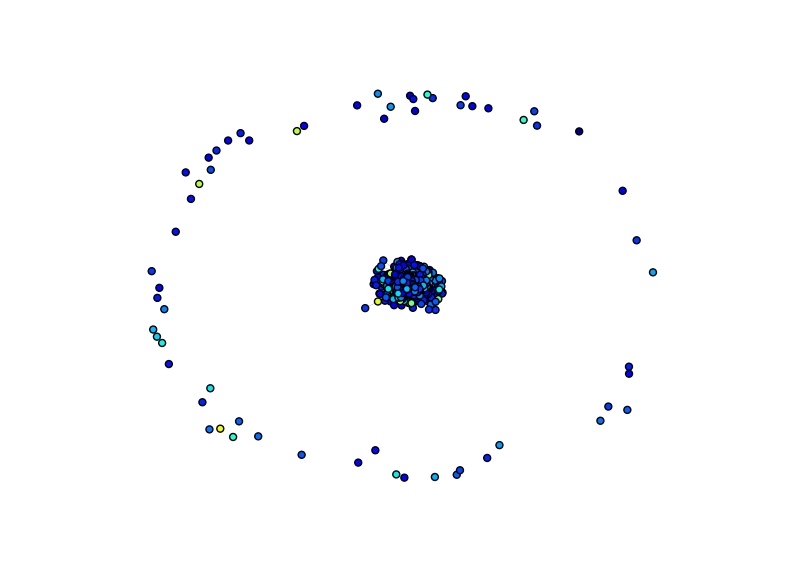

In [49]:
changed_score = {}
for gene, score in borda_scores.iteritems():
    changed_score[gene] = np.log2(float(score)/pval_scores[gene]*5)

scores = changed_score
keep_nodes = candidate_genes
G_community = G1.copy()
G_community = G_community.subgraph(keep_nodes)

node_attributes = {}
for node in G_community.nodes():
    if node not in scores.keys():
        node_attributes[node] = 0
    node_attributes[node] = scores[node]
nx.set_node_attributes(G_community, 'score', node_attributes)

values = nx.get_node_attributes(G_community,'score').values()
#nx.draw(G_community, cmap=plt.get_cmap('jet'), node_color=values, node_size=25, width=0.1)
nx.draw(G_community, cmap=plt.get_cmap('jet'), node_color=values, node_size=25, width=0.1)
plt.show()

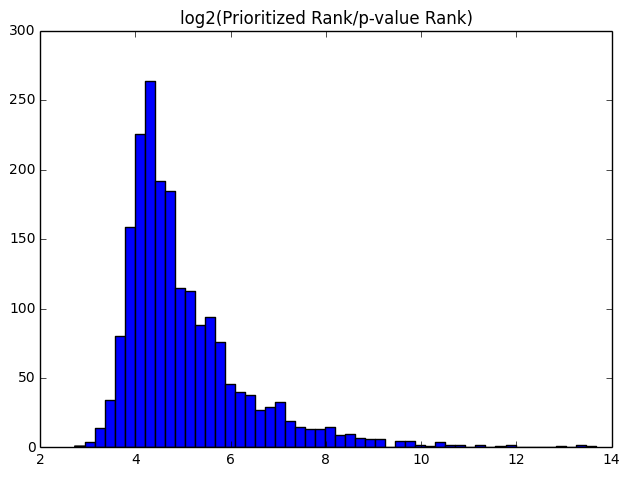

In [39]:
ls = []
for key, val in scores.iteritems():
    ls.append(val)
    
plt.hist(ls, bins='auto')
plt.title("log2(Prioritized Rank/p-value Rank)")
plt.show()

# Preparing the proteomic data

### Protein Normal Tissue

In [80]:
protein_atlas = pd.read_csv("data/normal_tissue.tsv", sep = "\t")
level_replace_dict = {"Not detected": 0, "Low": 1, "Medium":2, "High":3}
protein_atlas.replace({"Level": level_replace_dict}, inplace=True)

In [94]:
types = dict.fromkeys(set(, 0)
new_protein_atlas = pd.DataFrame(columns=types)
append_expression_dict = types
rename_index_dict = {0: "TSPAN6"}
count = 0
for index, row in protein_atlas.iterrows():
    if row["Gene name"] == rename_index_dict[count]:
        append_expression_dict[(row["Tissue"],row["Cell type"])] = row["Level"]
    else:
        new_protein_atlas = new_protein_atlas.append(append_expression_dict, ignore_index=True)
        count += 1
        append_expression_dict = types
        rename_index_dict[count] = row["Gene name"]
new_protein_atlas.rename(rename_index_dict, inplace=True, axis='index')  
new_protein_atlas.to_csv("new_protein_atlas.csv")

### RNA-seq Tissue Samples

In [170]:
tissue_atlas = pd.read_csv("data/rna_tissue.tsv", sep = "\t")
tissue_atlas.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [171]:
types = dict.fromkeys(set(tissue_atlas["Sample"]), 0)
new_tissue_atlas = pd.DataFrame(columns=types)
append_expression_dict = types
rename_index_dict = {0: "TSPAN6"}
count = 0
for index, row in tissue_atlas.iterrows():
    if row["Gene name"] == rename_index_dict[count]:
        append_expression_dict[row["Sample"]] = row["Value"]
    else:
        new_tissue_atlas = new_tissue_atlas.append(append_expression_dict, ignore_index=True)
        count += 1
        append_expression_dict = types
        rename_index_dict[count] = row["Gene name"]
new_tissue_atlas.rename(rename_index_dict, inplace=True, axis='index')  
new_tissue_atlas.to_csv("new_tissue_atlas.csv")

NameError: name 'new_protein_atlas' is not defined